## 1. Estimation of the Banana distribution

In this notebook, we will show how we can estimate a density $\pi$ given a limited number of samples $\boldsymbol{x}^i \sim \pi \in \mathbb{R}^{N_x}$. We will rely on the adaptive estimation framework developed in Baptista et al. [1].

References: 

[1] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[2] Marzouk, Y., Moselhy, T., Parno, M., & Spantini, A. (2016). Sampling via measure transport: An introduction. Handbook of uncertainty quantification, 1-41.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions

Load some packages to make nice figures

In [7]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Problem setup

 We start by generating $N_e$ samples from a banana distribution.

In [8]:
Ne = 500 # Number of samples
Nx = 2 # Dimension of the state

# Define the parameters of the banana distribution
μ = 0.0
σ = 2.0
bananicity = 0.3

# Generate the samples
X = sample_banana(Ne, μ = μ, σ = σ, bananicity = bananicity)

2×500 Matrix{Float64}:
 -0.906656  2.51432   0.819471   …   1.43602   -1.78594  -0.348171
 -1.49002   2.15296  -0.0162032     -0.534574  -1.1687    0.0189979

`X` is an ensemble matrix whose columns are the different ensemble members, i.e. $\boldsymbol{X} = 
\left[ \boldsymbol{x}^1, \ldots, \boldsymbol{x}^{N_e} \right]  \in \mathbb{R}^{N_x \times N_e}$.

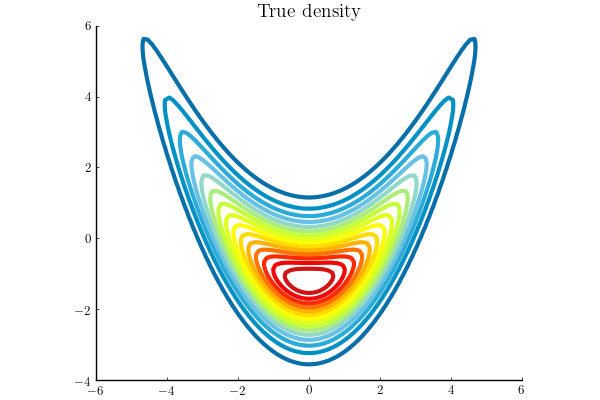

In [9]:
Nlog = 100
logbanana = zeros(Nlog, Nlog)

xrange = range(-6.0; stop = 6.0, length = Nlog)
yrange = range(-4.0; stop = 6.0, length = Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y]; μ = μ, σ = σ, bananicity = bananicity)
    end
end


contour(xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         colorbar = false, grid = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We define an object of  `HermiteMap` `S` to hold the Knothe-Rosenblatt rearrangement that pushes forward $\pi$ to the reference density, i.e. the standard Gaussian distribution $\rho$.
The default constructor for an `HermiteMap` requires, where $m$ is the maximal order of the Hermite polynomials considered in the expansion, $N_x$ the dimension of the state, $L$ a linear transformation that rescale the samples to get zero mean and unitary standard deviation component-wise, and $C$ an array of $N_x$ `MapComponent`.

In [29]:
m = 30
S = HermiteMap(m, X; diag = true);

The next step is to use the greedy algorithm developed by Baptista et al. (2020) to construct a sparse expansion of the different components of the map $S$. Depending on the accuracy of the amp required. Several options are possible for the optimization: 
* `kfold` uses a k-fold cross validation procedure (the more robust choice)
* `split` splits the set of samples into a training and a testing
* An `Int64` to determine the maximum number of features for each component $s^k$ of the map $S$
* `nothing` to simply optimize the existing coefficients in the basis expansion

In [30]:
@time optimize(S, X, "kfold"; withqr = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


  5.904406 seconds (3.54 M allocations: 9.760 GiB, 7.06% gc time, 0.33% compilation time)


HermiteMap(30, 2, LinearTransform(2, [0.1391687363679857, -0.026818430088076543], [2.0219412476280176 0.0; 0.0 2.0548861678529327], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 14 active features
])

The map $S$ is an approximation of the pushforward of the target density $\pi$, to the standard Gaussian density $\rho$.

We can access the different components of the map $S$ as follows:

In [12]:
S[1]

Map component of dimension 1 with Nψ 1 active features


In [13]:
S[2]

Map component of dimension 2 with Nψ 14 active features


`getidx` can be used to obtain the active features of the different map components. The number of columns is the number of dimensions. Each line correspond to a multi-index for the different components 

In [14]:
getidx(S[1])

1×1 Matrix{Int64}:
 1

Using `PlotRecipes.jl`, we plot the number of occurences of each variable (*columns*) in each map component (*rows*).

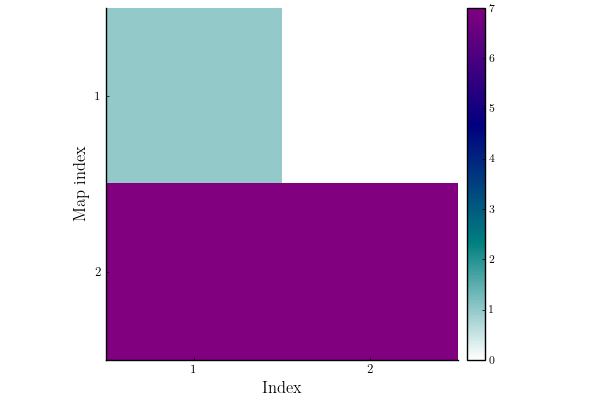

In [15]:
plot(S)

By setting `degree = true`, we plot maximum multi-index of the features identified for each variable (*columns*) in each map component (*rows*)

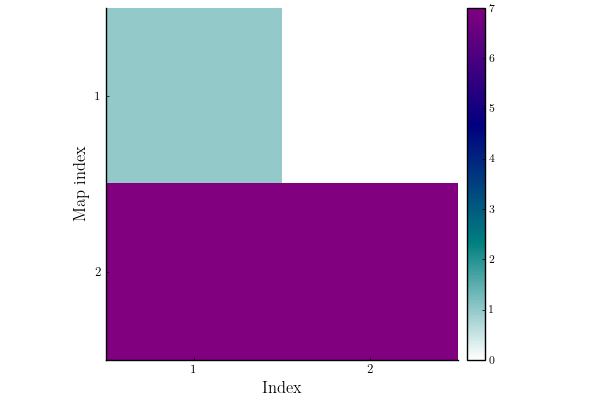

In [16]:
plot(S; degree = true)

  We can now compare the log-density of the true Banana density with the approximated one.

Let's create a grid and evaluate the logpdf the densities

In [17]:
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana_approx[i,j] = log_pdf(S, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

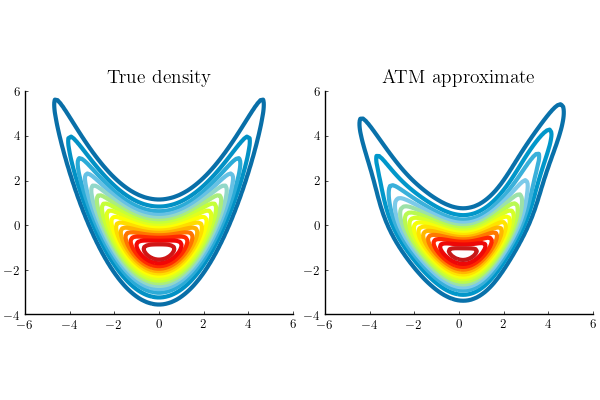

In [19]:
plt = plot(layout = grid(1, 2), colorbar = false, grid = false)
contour!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

contour!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1,
         title = "ATM approximate",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

W can overlap the estimated density with the sampples

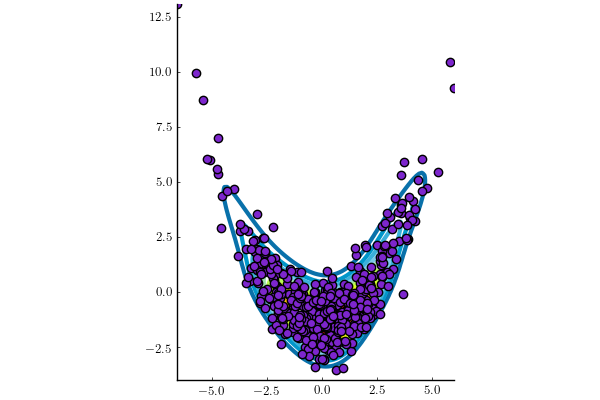

In [20]:
contour(xrange, yrange, exp.(logbanana_approx)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,:], X[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6)

By definition, the map $S$ pushes forward the samples $\boldsymbol{x}^i$ to the standard normal distribution $\rho$ of $\mathbb{R}^2$, denoted $\boldsymbol{S}_{\sharp} \pi = \rho$,  i.e. $\boldsymbol{x}^i \sim \pi \Rightarrow{} \boldsymbol{S}(\boldsymbol{x}^i) \sim \rho$

In [21]:
SpushX = evaluate(S, X)

2×500 Matrix{Float64}:
 -0.528735  1.16454  0.324745  -0.237173  …  0.63009   -0.962789  -0.252821
 -0.612784  1.32567  1.28463   -1.41353      0.210374  -1.00741    1.38401

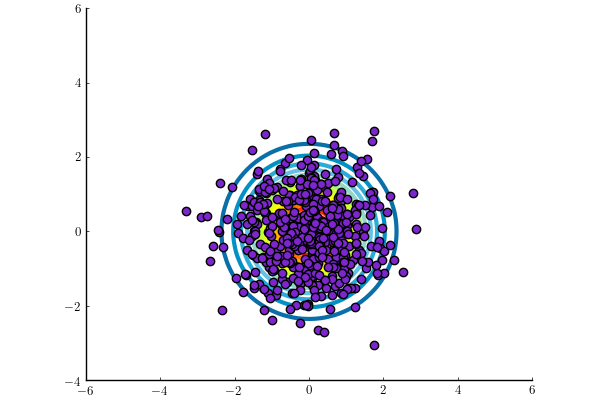

In [22]:
contour(xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(SpushX[1,:], SpushX[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6)

We can compute the statistics of the pushed samples

In [23]:
mean(SpushX; dims = 2)[:,1] # close to zero

2-element Vector{Float64}:
 -0.010799768476788908
  0.00026935736172067594

In [24]:
cov(SpushX; dims = 2) # close to the identity matrix 

2×2 Matrix{Float64}:
  0.999842    -0.00108019
 -0.00108019   0.999839

We can use the map $\boldsymbol{S}$ to generate new samples from the target density $\pi$. The map $\boldsymbol{S}$ pulls back  samples $\boldsymbol{z}^i$ of the standard normal distribution $\rho$ to the target density $\pi$, denoted $\boldsymbol{S}^{\sharp} \rho = \pi$, i.e. $\boldsymbol{z}^i \sim \rho \Rightarrow{} \boldsymbol{S}^{-1}(\boldsymbol{z}^i) \sim \pi$.

In [25]:
Znew = randn(Nx, Ne)
Xnew = zeros(Nx, Ne);

We use the in-place routine `inverse` to solve the triangular system $\boldsymbol{S}(\boldsymbol{x}^i) = \boldsymbol{z}^i$ for $\boldsymbol{x}^i \in \mathbb{R}^{N_x}$ for the different samples. From the lower triangular structure of $\boldsymbol{S}$, this inversion reduces to a sequence of one dimensional root finding problems Marzouk et al. [2].

In [26]:
inverse!(Xnew, copy(Znew), S)

2×500 Matrix{Float64}:
 -1.25477   -0.365602  -1.80672   …   2.15041   1.40693   -0.0334873
 -0.535159  -2.09238   -0.907992     -0.5754   -0.534392  -1.35032

In [27]:
evaluate(S, Xnew)-Znew

2×500 Matrix{Float64}:
 1.11022e-16  0.0          0.0          …  0.0          0.0
 1.66533e-16  1.11022e-16  6.66134e-16     3.60822e-16  9.85323e-16

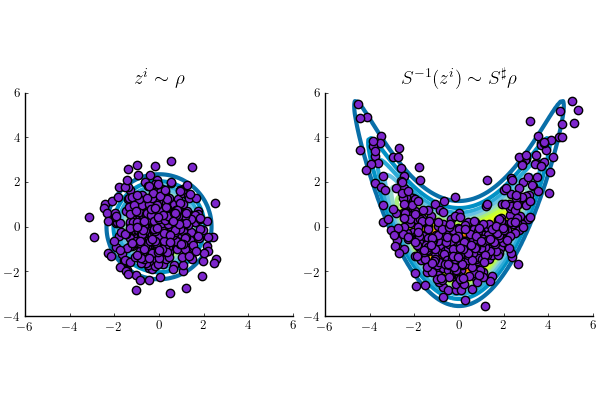

In [28]:
plt = plot(layout = grid(1, 2))

contour!(plt[1,1], xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,1], Znew[1,:], Znew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6, 
         title = L"z^i \sim \rho")

contour!(plt[1,2], xrange, yrange, exp.(logbanana)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,2], Xnew[1,:], Xnew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6,
            title = L"S^{-1}(z^i) \sim S^{\sharp}\rho")